### ITSM Ticket automation using RNN


1. NLP using LSTM to the Description of the problem
2. Run RNN for the attributes

In [1]:
import keras 
import numpy as np
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
data = pd.read_csv('/Users/jairomelo/Desktop/ML/YORK/ML1030/Capstone Project/incident 05-09-19.csv', encoding = "cp1252")

### Actions:
1. Balance the data sample.
2. Description has null values; we will use short description in case of missing description, and filter any record where no description nor short description is provided
3. Removing any occurence where 

In [3]:
# replacing na values in description with the Short Description 
data["Description"].fillna(data["Short_Description"], inplace = True) 
data = data.dropna(subset = ['Resolution_category'])


In [4]:
data.shape

(54750, 32)

In [5]:
#Cleaning Description using short description for observations recorded by Netcool Alerting tool
data['Description'] = data.apply(
    lambda row: row.Short_Description if 'Netcool Fields:' in row.Description else row.Description ,  axis = 1)

In [6]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,Assignment_group,State.1,Resolution_category,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved
0,INC000017612819,SIMS blank page when open with IE\r\n??IE ??S...,SIMS blank page,YUTONG ZHOU (152062324),Priority 4,Software,Website,Low,Limited,SIMS LATAM,...,GLOBAL SERVICE DESK,Closed Complete,Change Implementation,NaN,GLOBAL SERVICE DESK,JING HUANG (645010504),KB000010025934,LATAM,2017-11-12 21:03,2017-11-12 21:03
1,INC000020585404,"For dim_slt_id=203, dim_task_id=1658 exited wi...",TASK_STATUS - SLT ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Job Failure,Low,Limited,MENTOR BI SALES ANALYTICS,...,DATA AND ANALYTICS RR LTI,Closed Complete,Job Failure,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010080602,NaN,2019-08-04 3:30,2019-08-06 6:39
2,INC000020692831,"For DIM_SLT_ID=203, following task(s) violated...",TASK_END_DELAY violated for DIM_SLT_ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Poor performance,Low,Limited,MENTOR BI SALES ANALYTICS,...,DATA AND ANALYTICS RR LTI,Draft,Job Failure,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010081617,NaN,2019-08-24 2:15,2019-08-28 4:55
3,INC000017000450,??????,Software - J&J business applications: Unavaila...,ZHIYU ZHANG (85434123),Priority 4,Software,Website,Low,Localized,JJMC IPOWER -- PROF ED HCP MASTER DATABASE,...,AS MEDICAL APP CHINA L2,Closed Complete,User Access / Permission,ASPAC CN SHANGHAI,AS MEDICAL APP CHINA L2,WEI WANG (702020246),NaN,ASPAC,2017-06-27 3:26,2017-06-29 2:04
4,INC000017291067,> DS huddle Login issue,> DS huddle Login issue,SEAN FOLEY (702113126),Priority 4,Software,Desktop Software,Low,Localized,DS MOBILE,...,GLOBAL SERVICE DESK,Closed Complete,User Access / Permission,NA US NJ RARITAN,GLOBAL SERVICE DESK,ABEGAIL COMON (645001723),KB000010027981,NaN,2017-08-31 10:34,2017-08-31 14:36


In [7]:
#data = data.groupby('Resolution_category').filter(lambda x : len(x)>2000)

In [8]:
data.Resolution_category.value_counts()

Data Issue                                 15233
Job Failure                                14386
User Access / Permission                    5499
User knowledge or training error            4559
Incident Opened in Error / Not serviced     3908
Configuration Error                         3070
Connectivity                                2726
Application Defect (SDLC activities)        1138
Change Implementation                        940
Physical environmental failure               665
Interface or Middleware                      447
Capacity/ Disk Space                         399
Cancelled by user                            369
High Memory Utilization                      364
Software Bug (vendor)                        225
Security / Network password                  167
Software Incompatibility                     139
Missing Patch                                117
Supplies Low                                  87
SSO/Network                                   85
Broken/Damaged  (phy

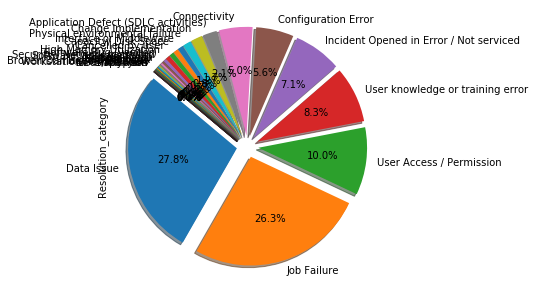

In [9]:
chart=data.Resolution_category.value_counts()
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
plot = chart.plot.pie(y='Resolution_category', figsize=(5, 5), explode=explode, subplots=True, autopct='%1.1f%%', shadow=True, startangle=140)

In [10]:
data['Resolution_category'] = data['Resolution_category'].map({'Data Issue':'Data Issue',
                                                               'Job Failure':'Job Failure',
                                                               'User Access / Permission':'User Access or Password',
                                                               'Security / Network password':'User Access or Password',
                                                               'User knowledge or training error':'User knowledge or training error',
                                                               'Incident Opened in Error / Not serviced': 'Open in Error or Ticket Cancelled',
                                                               'Cancelled by user':'Open in Error or Ticket Cancelled',
                                                               'Configuration Error':'Software',
                                                               'Software Incompatibility':'Software',
                                                               'Application Defect (SDLC activities)':'Software',
                                                               'Change Implementation':'Software',
                                                               'Interface or Middleware':'Software',
                                                               'Software Bug (vendor)':'Software',
                                                               'Missing Patch':'Software',
                                                               'High Memory Utilization':'Software',
                                                               'High CPU Usage':'Hardware',
                                                               'Connectivity':'Hardware',
                                                               'Physical environmental failure':'Hardware',
                                                               'Capacity/ Disk Space':'Hardware',
                                                               'Supplies Low':'Hardware',
                                                               'SSO/Network':'Hardware',
                                                               'Broken/Damaged  (physical)':'Hardware',
                                                               'Workstation Remediation':'Hardware',
                                                               'HD Encryption':'Hardware',
                                                               'Paper Jam':'Hardware',
                                                               'Virus/Malware':'Hardware'})

In [11]:
data.shape

(54750, 32)

In [12]:
data = data.dropna(subset = ['Resolution_category'])

In [13]:
data.shape

(54750, 32)

User Access / Permission
Security / Network password


data['Resolution_category'] = data.apply(
    lambda row: row.Short_Description if 'Netcool Fields:' in row.Description else row.Description ,  axis = 1)

Incident Opened in Error / Not serviced
Cancelled by user

Configuration Error
Software Incompatibility
Application Defect (SDLC activities)
Change Implementation
Interface or Middleware
Software Bug (vendor)
Missing Patch
High Memory Utilization


High CPU Usage
Connectivity
Physical environmental failure
Capacity/ Disk Space
Supplies Low
SSO/Network
Broken/Damaged  (physical)
Workstation Remediation
HD Encryption
Paper Jam
Virus/Malware


from sklearn.utils import resample

df_1 = data[data.Resolution_category=='Data Issue']
df_2 = data[data.Resolution_category=='Job Failure']
df_3 = data[data.Resolution_category=='User Access / Permission']
df_4 = data[data.Resolution_category=='User knowledge or training error']
df_5 = data[data.Resolution_category=='Incident Opened in Error / Not serviced']
df_6 = data[data.Resolution_category=='Configuration Error']
df_7 = data[data.Resolution_category=='Connectivity']


df_1_upsampled = resample(df_1, 
                                 replace=True,     # sample with replacement
                                 n_samples=2726,    # to match majority class
                                 random_state=123) # reproducible results

df_2_upsampled = resample(df_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=2726,    # to match majority class
                                 random_state=123) # reproducible results

df_3_upsampled = resample(df_3, 
                                 replace=True,     # sample with replacement
                                 n_samples=2726,    # to match majority class
                                 random_state=123) # reproducible results

df_4_upsampled = resample(df_4, 
                                 replace=True,     # sample with replacement
                                 n_samples=2726,    # to match majority class
                                 random_state=123) # reproducible results

df_5_upsampled = resample(df_5, 
                                 replace=True,     # sample with replacement
                                 n_samples=2726,    # to match majority class
                                 random_state=123) # reproducible results

df_6_upsampled = resample(df_6, 
                                 replace=True,     # sample with replacement
                                 n_samples=2726,    # to match majority class
                                 random_state=123) # reproducible results

df_7_upsampled = resample(df_7, 
                                 replace=True,     # sample with replacement
                                 n_samples=2726,    # to match majority class
                                 random_state=123) # reproducible results


# Combine majority class with upsampled minority class
data = pd.concat([df_1_upsampled, df_2_upsampled, df_3_upsampled, df_4_upsampled, df_5_upsampled, df_6_upsampled, df_7_upsampled])

In [14]:
data.Resolution_category.value_counts()

Data Issue                           15233
Job Failure                          14386
Software                              6440
User Access or Password               5666
User knowledge or training error      4559
Open in Error or Ticket Cancelled     4277
Hardware                              4189
Name: Resolution_category, dtype: int64

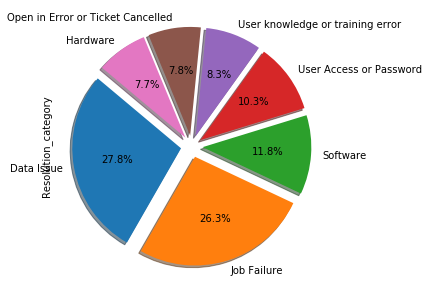

In [15]:
chart=data.Resolution_category.value_counts()
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
plot = chart.plot.pie(y='Resolution_category', figsize=(5, 5), explode=explode, subplots=True, autopct='%1.1f%%', shadow=True, startangle=140)

In [16]:
data.Resolution_category.value_counts()

Data Issue                           15233
Job Failure                          14386
Software                              6440
User Access or Password               5666
User knowledge or training error      4559
Open in Error or Ticket Cancelled     4277
Hardware                              4189
Name: Resolution_category, dtype: int64

In [17]:
data['target_sol'] = data.Resolution_category.astype('category').cat.codes

In [18]:
labels_sol = data.Resolution_category.astype('category').cat.categories

In [19]:
df = pd.DataFrame(labels_sol) 
df.to_csv ('/Users/jairomelo/Desktop/ML/YORK/ML1030/Capstone Project/labels_sol.csv')

In [20]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,State.1,Resolution_category,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved,target_sol
0,INC000017612819,SIMS blank page when open with IE\r\n??IE ??S...,SIMS blank page,YUTONG ZHOU (152062324),Priority 4,Software,Website,Low,Limited,SIMS LATAM,...,Closed Complete,Software,NaN,GLOBAL SERVICE DESK,JING HUANG (645010504),KB000010025934,LATAM,2017-11-12 21:03,2017-11-12 21:03,4
1,INC000020585404,"For dim_slt_id=203, dim_task_id=1658 exited wi...",TASK_STATUS - SLT ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Job Failure,Low,Limited,MENTOR BI SALES ANALYTICS,...,Closed Complete,Job Failure,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010080602,NaN,2019-08-04 3:30,2019-08-06 6:39,2
2,INC000020692831,"For DIM_SLT_ID=203, following task(s) violated...",TASK_END_DELAY violated for DIM_SLT_ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Poor performance,Low,Limited,MENTOR BI SALES ANALYTICS,...,Draft,Job Failure,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010081617,NaN,2019-08-24 2:15,2019-08-28 4:55,2
3,INC000017000450,??????,Software - J&J business applications: Unavaila...,ZHIYU ZHANG (85434123),Priority 4,Software,Website,Low,Localized,JJMC IPOWER -- PROF ED HCP MASTER DATABASE,...,Closed Complete,User Access or Password,ASPAC CN SHANGHAI,AS MEDICAL APP CHINA L2,WEI WANG (702020246),NaN,ASPAC,2017-06-27 3:26,2017-06-29 2:04,5
4,INC000017291067,> DS huddle Login issue,> DS huddle Login issue,SEAN FOLEY (702113126),Priority 4,Software,Desktop Software,Low,Localized,DS MOBILE,...,Closed Complete,User Access or Password,NA US NJ RARITAN,GLOBAL SERVICE DESK,ABEGAIL COMON (645001723),KB000010027981,NaN,2017-08-31 10:34,2017-08-31 14:36,5


In [21]:
data['num_words'] = data['Description'].apply(lambda x : len(x.split()))

In [54]:
bins=[0,50,75, np.inf]
data['bins']=pd.cut(data.num_words, bins=[0,10,20,50,300, np.inf], labels=['0-10', '10-20', '20-50','50-300' ,'>300'])


In [55]:
word_distribution = data.groupby('bins').size().reset_index().rename(columns={0:'counts'})

In [56]:
word_distribution.head()

,bins,counts
0,0-10,13351
1,10-20,19972
2,20-50,11914
3,50-300,9412
4,>300,100


Text(0.5, 1.0, 'Word distribution per bin')

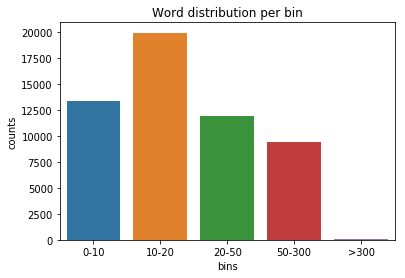

In [57]:
sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

In [58]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved,target_sol,num_words,bins
0,INC000017612819,SIMS blank page when open with IE\r\n??IE ??S...,SIMS blank page,YUTONG ZHOU (152062324),Priority 4,Software,Website,Low,Limited,SIMS LATAM,...,NaN,GLOBAL SERVICE DESK,JING HUANG (645010504),KB000010025934,LATAM,2017-11-12 21:03,2017-11-12 21:03,4,10,0-10
1,INC000020585404,"For dim_slt_id=203, dim_task_id=1658 exited wi...",TASK_STATUS - SLT ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Job Failure,Low,Limited,MENTOR BI SALES ANALYTICS,...,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010080602,NaN,2019-08-04 3:30,2019-08-06 6:39,2,8,0-10
2,INC000020692831,"For DIM_SLT_ID=203, following task(s) violated...",TASK_END_DELAY violated for DIM_SLT_ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Poor performance,Low,Limited,MENTOR BI SALES ANALYTICS,...,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010081617,NaN,2019-08-24 2:15,2019-08-28 4:55,2,20,10-20
3,INC000017000450,??????,Software - J&J business applications: Unavaila...,ZHIYU ZHANG (85434123),Priority 4,Software,Website,Low,Localized,JJMC IPOWER -- PROF ED HCP MASTER DATABASE,...,ASPAC CN SHANGHAI,AS MEDICAL APP CHINA L2,WEI WANG (702020246),NaN,ASPAC,2017-06-27 3:26,2017-06-29 2:04,5,1,0-10
4,INC000017291067,> DS huddle Login issue,> DS huddle Login issue,SEAN FOLEY (702113126),Priority 4,Software,Desktop Software,Low,Localized,DS MOBILE,...,NA US NJ RARITAN,GLOBAL SERVICE DESK,ABEGAIL COMON (645001723),KB000010027981,NaN,2017-08-31 10:34,2017-08-31 14:36,5,5,0-10


In [59]:
arreglo = data.Resolution_category.values

In [60]:
np.unique(arreglo)

array(['Data Issue', 'Hardware', 'Job Failure',
       'Open in Error or Ticket Cancelled', 'Software',
       'User Access or Password', 'User knowledge or training error'],
      dtype=object)

In [61]:
num_class_sol = len(np.unique(data.Resolution_category.values))
y_sol = data['target_sol'].values


## Topic Modelling

In [62]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np
import pandas as pd
import re
import warnings
from sklearn.metrics import confusion_matrix
#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
#from mpl_toolkits.basemap import Basemap
from wordcloud import WordCloud, STOPWORDS

#nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

In [63]:
data['Description'] = data['Description'].astype(str)

In [64]:
type(data['Description'])

pandas.core.series.Series

In [65]:
data_description = data.Description.values

In [66]:
type(data_description)

numpy.ndarray

In [67]:
#cv = # Initialize a CountVectorizer object: count_vectorizer
count_vec = CountVectorizer(stop_words="english", analyzer='word', 
                            ngram_range=(1, 1), max_df=1, min_df=1, max_features=None)

# convert text data into term-frequency matrix
data_description = count_vec.fit_transform(data_description)




tfidf_transformer = TfidfTransformer()

# convert term-frequency matrix into tf-idf
tfidf_matrix = tfidf_transformer.fit_transform(data_description)

# create dictionary to find a tfidf word each word
word2tfidf = dict(zip(count_vec.get_feature_names(), tfidf_transformer.idf_))

for word, score in word2tfidf.items():
    print(word, score)

0000000 11.217403731792185
000000000 11.217403731792185
000000000000019445 11.217403731792185
000000000000080001 11.217403731792185
000000000000080002 11.217403731792185
000000000000080003 11.217403731792185
000000000000080004 11.217403731792185
000000000000080005 11.217403731792185
000000000000080006 11.217403731792185
000000000000080007 11.217403731792185
000000000000080008 11.217403731792185
000000000000080009 11.217403731792185
000000000000080010 11.217403731792185
000000000000080011 11.217403731792185
000000000000080015 11.217403731792185
000000000000080018 11.217403731792185
000000000000080019 11.217403731792185
000000000000080020 11.217403731792185
000000000000080021 11.217403731792185
000000000000080022 11.217403731792185
000000000000080023 11.217403731792185
000000000000080024 11.217403731792185
000000000000080025 11.217403731792185
000000000000080026 11.217403731792185
000000000000080027 11.217403731792185
000000000000080028 11.217403731792185
000000000000080029 11.2174037317

00240865 11.217403731792185
002420 11.217403731792185
002440 11.217403731792185
002485 11.217403731792185
0024987 11.217403731792185
002520 11.217403731792185
002529 11.217403731792185
0025527 11.217403731792185
002555 11.217403731792185
002560 11.217403731792185
002577 11.217403731792185
0026 11.217403731792185
002608 11.217403731792185
002609 11.217403731792185
002657 11.217403731792185
002659 11.217403731792185
002663 11.217403731792185
002670 11.217403731792185
00268336 11.217403731792185
002691 11.217403731792185
0027 11.217403731792185
002710 11.217403731792185
00277 11.217403731792185
002870 11.217403731792185
002888 11.217403731792185
002890 11.217403731792185
0029 11.217403731792185
002964 11.217403731792185
002970 11.217403731792185
0029885 11.217403731792185
00299 11.217403731792185
0029m 11.217403731792185
00300450242136 11.217403731792185
00300450242259 11.217403731792185
00300450449108 11.217403731792185
00300450488404 11.217403731792185
00300810730877 11.217403731792185


06265t 11.217403731792185
06266t 11.217403731792185
06267t 11.217403731792185
062cfd3b 11.217403731792185
06305t 11.217403731792185
0630900001 11.217403731792185
06309t 11.217403731792185
06331t 11.217403731792185
0635400001 11.217403731792185
0635900001 11.217403731792185
0636f3264 11.217403731792185
0641 11.217403731792185
06508 11.217403731792185
06516t 11.217403731792185
0655299002 11.217403731792185
065556202 11.217403731792185
0659901011 11.217403731792185
0659901300 11.217403731792185
0659903002 11.217403731792185
0659903004 11.217403731792185
066014500 11.217403731792185
0660190301 11.217403731792185
0660301300 11.217403731792185
0665350001 11.217403731792185
066k 11.217403731792185
067 11.217403731792185
0670212001 11.217403731792185
067021s001 11.217403731792185
06703t 11.217403731792185
06711 11.217403731792185
06712 11.217403731792185
06757 11.217403731792185
0682 11.217403731792185
06899 11.217403731792185
069e83aa 11.217403731792185
06_10 11.217403731792185
06c9 11.217403

13305432089 11.217403731792185
1330929 11.217403731792185
133123239 11.217403731792185
133134854 11.217403731792185
1332 11.217403731792185
13326 11.217403731792185
1333907 11.217403731792185
1335 11.217403731792185
133813324 11.217403731792185
133866 11.217403731792185
133876 11.217403731792185
1339 11.217403731792185
134106 11.217403731792185
134196 11.217403731792185
1342 11.217403731792185
13440 11.217403731792185
1344179 11.217403731792185
1347 11.217403731792185
134769990 11.217403731792185
1348 11.217403731792185
13481 11.217403731792185
13483 11.217403731792185
134k 11.217403731792185
1350 11.217403731792185
13501 11.217403731792185
13506 11.217403731792185
13538 11.217403731792185
135461 11.217403731792185
13550 11.217403731792185
135557 11.217403731792185
135744059 11.217403731792185
1357888058410835 11.217403731792185
1359774 11.217403731792185
1360 11.217403731792185
1361736 11.217403731792185
1364 11.217403731792185
1364265 11.217403731792185
13665 11.217403731792185
13665

1920 11.217403731792185
19213198 11.217403731792185
1923 11.217403731792185
19235645 11.217403731792185
19235648 11.217403731792185
19265411 11.217403731792185
19266431 11.217403731792185
19276053 11.217403731792185
19292269 11.217403731792185
19292845 11.217403731792185
19292902 11.217403731792185
19355 11.217403731792185
19364 11.217403731792185
193757 11.217403731792185
19392 11.217403731792185
19393 11.217403731792185
1939564 11.217403731792185
194 11.217403731792185
19429842 11.217403731792185
19444 11.217403731792185
19445 11.217403731792185
19450 11.217403731792185
194611 11.217403731792185
19500143 11.217403731792185
19500348 11.217403731792185
1956020 11.217403731792185
1956user 11.217403731792185
19574725 11.217403731792185
19578195 11.217403731792185
19580 11.217403731792185
195800 11.217403731792185
195k 11.217403731792185
19602897 11.217403731792185
1960375ur4z5b 11.217403731792185
19608344 11.217403731792185
19619 11.217403731792185
196545 11.217403731792185
1968 11.21740

2178 11.217403731792185
217952 11.217403731792185
2180 11.217403731792185
21806 11.217403731792185
21807 11.217403731792185
21808 11.217403731792185
21809964010 11.217403731792185
2181 11.217403731792185
218196 11.217403731792185
2182 11.217403731792185
218282 11.217403731792185
21830311 11.217403731792185
218632 11.217403731792185
2187 11.217403731792185
2188 11.217403731792185
218k 11.217403731792185
21902 11.217403731792185
219107 11.217403731792185
219296 11.217403731792185
219302 11.217403731792185
219483 11.217403731792185
219484 11.217403731792185
21949 11.217403731792185
2195 11.217403731792185
219541 11.217403731792185
219658 11.217403731792185
2199 11.217403731792185
219913 11.217403731792185
21am 11.217403731792185
21jeffery 11.217403731792185
21m 11.217403731792185
21pm 11.217403731792185
21stand 11.217403731792185
21th 11.217403731792185
220001 11.217403731792185
220044 11.217403731792185
2201 11.217403731792185
220128 11.217403731792185
220463 11.217403731792185
220495 11

26394 11.217403731792185
26395 11.217403731792185
26396 11.217403731792185
26397 11.217403731792185
26398 11.217403731792185
26399 11.217403731792185
2639k 11.217403731792185
26400 11.217403731792185
26401 11.217403731792185
26402 11.217403731792185
26403 11.217403731792185
26404 11.217403731792185
26405 11.217403731792185
26406 11.217403731792185
2641 11.217403731792185
2645 11.217403731792185
264679010600000318 11.217403731792185
2647 11.217403731792185
26477 11.217403731792185
264kusd 11.217403731792185
265020994 11.217403731792185
26502268 11.217403731792185
2651 11.217403731792185
26550 11.217403731792185
26632 11.217403731792185
2665 11.217403731792185
2670 11.217403731792185
26755 11.217403731792185
26774 11.217403731792185
2678 11.217403731792185
2680733302 11.217403731792185
26807347 11.217403731792185
2680735801 11.217403731792185
26807359 11.217403731792185
268220855 11.217403731792185
26828084 11.217403731792185
2684 11.217403731792185
26850 11.217403731792185
268545830 11.

39minutes 11.217403731792185
39nina 11.217403731792185
39pm 11.217403731792185
39robert 11.217403731792185
3_ntssku 11.217403731792185
3a443 11.217403731792185
3a46 11.217403731792185
3a474db49074 11.217403731792185
3a4a41ba 11.217403731792185
3a5 11.217403731792185
3a56 11.217403731792185
3a5e 11.217403731792185
3a61 11.217403731792185
3aba9af6e55918da3292e660c6d79705377971f3 11.217403731792185
3abrowserbackbuttonundo 11.217403731792185
3af798cb93bc 11.217403731792185
3aitis 11.217403731792185
3ajsdebug 11.217403731792185
3aoct2018 11.217403731792185
3aopenauthoringintopwindow 11.217403731792185
3aoriginal_view 11.217403731792185
3ap100020105 11.217403731792185
3ap10014 11.217403731792185
3ap10025 11.217403731792185
3areloadoncustomviewsave 11.217403731792185
3asize 11.217403731792185
3ausingoldhashurl 11.217403731792185
3b 11.217403731792185
3b8d 11.217403731792185
3bff 11.217403731792185
3c 11.217403731792185
3c2f5c48 11.217403731792185
3cb 11.217403731792185
3cbefb6e47d3 11.2174037

4318858 11.217403731792185
4318859 11.217403731792185
4318864 11.217403731792185
4318865 11.217403731792185
4318868 11.217403731792185
4319 11.217403731792185
4319022 11.217403731792185
4319415 11.217403731792185
4319416 11.217403731792185
4319530 11.217403731792185
4319532 11.217403731792185
4319728 11.217403731792185
4319730 11.217403731792185
4319821 11.217403731792185
4320 11.217403731792185
4320224 11.217403731792185
4320233 11.217403731792185
4320241 11.217403731792185
4320261 11.217403731792185
4320263 11.217403731792185
4320390 11.217403731792185
4320940 11.217403731792185
4320955 11.217403731792185
4320976 11.217403731792185
432100 11.217403731792185
4321390 11.217403731792185
4321547 11.217403731792185
4322 11.217403731792185
4322061 11.217403731792185
4322085 11.217403731792185
4322507 11.217403731792185
4322508 11.217403731792185
4322613 11.217403731792185
4322621 11.217403731792185
4322630 11.217403731792185
4324851 11.217403731792185
4325223 11.217403731792185
4325224 11.

4440 11.217403731792185
4440589 11.217403731792185
4441422 11.217403731792185
4442 11.217403731792185
4442144 11.217403731792185
4443124 11.217403731792185
4443711 11.217403731792185
4444 11.217403731792185
4444479 11.217403731792185
4445096 11.217403731792185
4445259 11.217403731792185
4445546 11.217403731792185
4446110 11.217403731792185
4446859 11.217403731792185
4447 11.217403731792185
4447523 11.217403731792185
4447524 11.217403731792185
4447527 11.217403731792185
4447691 11.217403731792185
44480mb 11.217403731792185
4448283 11.217403731792185
4448289 11.217403731792185
4448347 11.217403731792185
4448391 11.217403731792185
4448420 11.217403731792185
4448600 11.217403731792185
4448668 11.217403731792185
4449397 11.217403731792185
4449849 11.217403731792185
4449850 11.217403731792185
4449857 11.217403731792185
4450 11.217403731792185
4450076 11.217403731792185
4450138 11.217403731792185
4451901 11.217403731792185
4451925 11.217403731792185
4452619 11.217403731792185
4452620 11.21740

4739821 11.217403731792185
4740114 11.217403731792185
4740116 11.217403731792185
4740140 11.217403731792185
4740141 11.217403731792185
4740442 11.217403731792185
4740463 11.217403731792185
4740491 11.217403731792185
4740720 11.217403731792185
4740721 11.217403731792185
4740722 11.217403731792185
4740723 11.217403731792185
4740724 11.217403731792185
4740897 11.217403731792185
4740904 11.217403731792185
4740993 11.217403731792185
4740994 11.217403731792185
4741320 11.217403731792185
4741955 11.217403731792185
4742536 11.217403731792185
4743 11.217403731792185
4743142 11.217403731792185
4743703 11.217403731792185
4744127 11.217403731792185
4744200 11.217403731792185
47447 11.217403731792185
4744838 11.217403731792185
474530 11.217403731792185
4745635 11.217403731792185
4746132 11.217403731792185
4746805 11.217403731792185
4747 11.217403731792185
4747494 11.217403731792185
4748128 11.217403731792185
4748816 11.217403731792185
4749346 11.217403731792185
4749784 11.217403731792185
4749900 11

5038859 11.217403731792185
5038875 11.217403731792185
5038880 11.217403731792185
5038965 11.217403731792185
5039181 11.217403731792185
50396 11.217403731792185
5039708780 11.217403731792185
5041180 11.217403731792185
5041188 11.217403731792185
5041190 11.217403731792185
5041298 11.217403731792185
5041369 11.217403731792185
5041413 11.217403731792185
5041450 11.217403731792185
5041617 11.217403731792185
5041619 11.217403731792185
5041627 11.217403731792185
5041629 11.217403731792185
5041765 11.217403731792185
5042855 11.217403731792185
50432098 11.217403731792185
5043721 11.217403731792185
5044283 11.217403731792185
5044285 11.217403731792185
5044633 11.217403731792185
5045810 11.217403731792185
5046 11.217403731792185
5046283 11.217403731792185
5046417 11.217403731792185
5046776 11.217403731792185
5047023 11.217403731792185
5047615 11.217403731792185
5047976 11.217403731792185
50490 11.217403731792185
5049006 11.217403731792185
5049441 11.217403731792185
5049952 11.217403731792185
5049

6269866 11.217403731792185
6272234 11.217403731792185
6273 11.217403731792185
628 11.217403731792185
628304 11.217403731792185
6285959 11.217403731792185
6286 11.217403731792185
6290000 11.217403731792185
6292 11.217403731792185
6293 11.217403731792185
629565216 11.217403731792185
6298366 11.217403731792185
6299 11.217403731792185
6299999 11.217403731792185
62f0c1e013e35b40371f50bf3244b025 11.217403731792185
62f6cab4 11.217403731792185
62mm 11.217403731792185
63000 11.217403731792185
6300391 11.217403731792185
6303 11.217403731792185
630900001 11.217403731792185
630k 11.217403731792185
6310000 11.217403731792185
6310001 11.217403731792185
6310002 11.217403731792185
6310003 11.217403731792185
6310004 11.217403731792185
6310005 11.217403731792185
6319 11.217403731792185
6320 11.217403731792185
6320000 11.217403731792185
6320001 11.217403731792185
6320002 11.217403731792185
6320003 11.217403731792185
6320004 11.217403731792185
6320005 11.217403731792185
6322 11.217403731792185
63253 11.21

702187099 11.217403731792185
702190464 11.217403731792185
702192981 11.217403731792185
702193636 11.217403731792185
702193788 11.217403731792185
702198236 11.217403731792185
702199178 11.217403731792185
702200147 11.217403731792185
702201557 11.217403731792185
702201673 11.217403731792185
702206421 11.217403731792185
702207303 11.217403731792185
702207383 11.217403731792185
702208677 11.217403731792185
702209631 11.217403731792185
702210231 11.217403731792185
702211795 11.217403731792185
702212199 11.217403731792185
702212360 11.217403731792185
702213998 11.217403731792185
702215805 11.217403731792185
702215850 11.217403731792185
702216097 11.217403731792185
702218055 11.217403731792185
702220148 11.217403731792185
702222234 11.217403731792185
702222573 11.217403731792185
702223276 11.217403731792185
702224393 11.217403731792185
702224847 11.217403731792185
702227948 11.217403731792185
702228120 11.217403731792185
702228140 11.217403731792185
702228883 11.217403731792185
702230389 11.2

8490 11.217403731792185
84b6 11.217403731792185
84d7b1694fb0360c8577c3a01210c7db 11.217403731792185
84k 11.217403731792185
8500151157 11.217403731792185
8500151871 11.217403731792185
85014928 11.217403731792185
85042246 11.217403731792185
8507 11.217403731792185
8508 11.217403731792185
850cc 11.217403731792185
851 11.217403731792185
8511 11.217403731792185
85123501 11.217403731792185
85138 11.217403731792185
851762957 11.217403731792185
8518 11.217403731792185
8519 11.217403731792185
8520153307 11.217403731792185
8520154042 11.217403731792185
852331111issue 11.217403731792185
85259048 11.217403731792185
852659 11.217403731792185
8526599 11.217403731792185
85279750 11.217403731792185
85280825 11.217403731792185
852837100000 11.217403731792185
85307639 11.217403731792185
85312862 11.217403731792185
85316424 11.217403731792185
853279160000 11.217403731792185
85331 11.217403731792185
8538 11.217403731792185
853b 11.217403731792185
8540149545 11.217403731792185
8540150230 11.217403731792185

abstractaspectjadvice 11.217403731792185
abstractauthservice 11.217403731792185
abstractfallbacksqlexceptiontranslator 11.217403731792185
abstractfunction0 11.217403731792185
abstractjdbc2statement 11.217403731792185
abstractjob 11.217403731792185
abstractresourcemethoddispatchprovider 11.217403731792185
absurd 11.217403731792185
abteilungswebs 11.217403731792185
abub 11.217403731792185
abumn 11.217403731792185
aburrf 11.217403731792185
abusharar 11.217403731792185
abvp 11.217403731792185
abwz 11.217403731792185
abwählen 11.217403731792185
abxb 11.217403731792185
abxi 11.217403731792185
abxx 11.217403731792185
abyj 11.217403731792185
ac00bebce98d 11.217403731792185
ac07 11.217403731792185
ac0fb9ec 11.217403731792185
ac1025 11.217403731792185
ac1300 11.217403731792185
ac15 11.217403731792185
ac2e 11.217403731792185
ac347cd73036 11.217403731792185
ac3534e20f4e 11.217403731792185
ac55 11.217403731792185
ac87a0f564aa 11.217403731792185
acabo 11.217403731792185
acadia 11.217403731792185
aca

amoapps55 11.217403731792185
amol 11.217403731792185
amolms 11.217403731792185
amoura7 11.217403731792185
amoutns 11.217403731792185
amoy 11.217403731792185
amp 11.217403731792185
ampil_prd 11.217403731792185
amprocessdashboard_0 11.217403731792185
amrit 11.217403731792185
amserver 11.217403731792185
amt_obj_crcy 11.217403731792185
amvendorgovernanceedl 11.217403731792185
amy 11.217403731792185
américa 11.217403731792185
an158993 11.217403731792185
an159050 11.217403731792185
an180112 11.217403731792185
an417155 11.217403731792185
an418957 11.217403731792185
an5 11.217403731792185
an66401 11.217403731792185
an8 11.217403731792185
anabella 11.217403731792185
anabelle 11.217403731792185
anad 11.217403731792185
anagara1 11.217403731792185
anaid 11.217403731792185
analaytical 11.217403731792185
analaytics 11.217403731792185
analia 11.217403731792185
analise 11.217403731792185
analises 11.217403731792185
analisis 11.217403731792185
analisisdeventa 11.217403731792185
analisou 11.217403731792

atender 11.217403731792185
athentication 11.217403731792185
atherley 11.217403731792185
athira 11.217403731792185
athirun 11.217403731792185
ativar 11.217403731792185
atividade 11.217403731792185
atividades 11.217403731792185
ativos 11.217403731792185
atlas_ecgcp_int09 11.217403731792185
atlasintdwh 11.217403731792185
atlmaviva 11.217403731792185
atm_party 11.217403731792185
atms 11.217403731792185
atomic 11.217403731792185
atopica 11.217403731792185
atos_1006 11.217403731792185
atos_1007 11.217403731792185
atos_1007incglobalchat 11.217403731792185
atos_1010 11.217403731792185
atos_1012 11.217403731792185
atos_1031 11.217403731792185
atos_1083 11.217403731792185
atp_domestic_plant 11.217403731792185
atpcsbw01 11.217403731792185
atpcsbw02 11.217403731792185
atpcsdps02 11.217403731792185
atprctrandaccount 11.217403731792185
atr 11.217403731792185
atrasa 11.217403731792185
atrasada 11.217403731792185
atrasar 11.217403731792185
atrasi 11.217403731792185
atrelado 11.217403731792185
atrelado

boucle 11.217403731792185
bouge 11.217403731792185
bough 11.217403731792185
boughtwindows 11.217403731792185
boulevard 11.217403731792185
bounceback 11.217403731792185
bounced 11.217403731792185
bound 11.217403731792185
boundaries 11.217403731792185
boundsplasticsurgery 11.217403731792185
bourji 11.217403731792185
bournigal 11.217403731792185
boutique 11.217403731792185
boven 11.217403731792185
bovenaan 11.217403731792185
bowen 11.217403731792185
box_webinar 11.217403731792185
boxer_raw_sales 11.217403731792185
boyarkina 11.217403731792185
bp18 11.217403731792185
bp19 11.217403731792185
bp2018 11.217403731792185
bp_sales_amount 11.217403731792185
bp_source_input 11.217403731792185
bpandey4 11.217403731792185
bpaul7 11.217403731792185
bpc 11.217403731792185
bpe 11.217403731792185
bpearce3 11.217403731792185
bph 11.217403731792185
bpmng 11.217403731792185
bpms 11.217403731792185
bpt 11.217403731792185
bptmain 11.217403731792185
bq20 11.217403731792185
bq20tx 11.217403731792185
bq22 11.21

chn_emp_cd 11.217403731792185
chn_emp_nm_knj 11.217403731792185
chn_lgl_nm 11.217403731792185
chnage 11.217403731792185
chnl_key 11.217403731792185
chokchai 11.217403731792185
chome 11.217403731792185
chongmd 11.217403731792185
chongqingyishengtangmaoyi 11.217403731792185
chordia 11.217403731792185
chorme 11.217403731792185
chosable 11.217403731792185
chosing 11.217403731792185
chotmongkol 11.217403731792185
chou7 11.217403731792185
chowdary 11.217403731792185
chp 11.217403731792185
chr 11.217403731792185
chrage 11.217403731792185
christel 11.217403731792185
christi 11.217403731792185
christiaan 11.217403731792185
christmas 11.217403731792185
christy 11.217403731792185
chrn_ind 11.217403731792185
chromerun 11.217403731792185
chu21 11.217403731792185
chuanxin 11.217403731792185
chuen 11.217403731792185
chung 11.217403731792185
chunked 11.217403731792185
chunks 11.217403731792185
chunksize 11.217403731792185
chyrell 11.217403731792185
chyrun 11.217403731792185
ci000000007602676 11.217403

conbw32_cog_gnp_con_bscca_cog_cubes_wky_thr 11.217403731792185
conbw32_gnp_infa_conca_biw_cloudera 11.217403731792185
conbwp1 11.217403731792185
conca_biw 11.217403731792185
conca_biw_cloudera_ld_prod 11.217403731792185
conca_biw_diq_adm 11.217403731792185
conca_biw_direct_dim_material 11.217403731792185
conca_biw_direct_fact_cust_delivery 11.217403731792185
conca_biw_direct_fact_stg 11.217403731792185
conca_biw_loblaws 11.217403731792185
conca_biw_report_spt 11.217403731792185
concatenate 11.217403731792185
concatenated 11.217403731792185
concentrate 11.217403731792185
concentrated 11.217403731792185
concepts 11.217403731792185
concernes 11.217403731792185
conch 11.217403731792185
conciliation 11.217403731792185
concluem 11.217403731792185
conclui 11.217403731792185
concluidas 11.217403731792185
conclusions 11.217403731792185
conclusão 11.217403731792185
concluída 11.217403731792185
concn 11.217403731792185
concordance 11.217403731792185
concour 11.217403731792185
concrned 11.21740373

demantra 11.217403731792185
demarinis 11.217403731792185
demasiado 11.217403731792185
demir 11.217403731792185
demms 11.217403731792185
demographic 11.217403731792185
demonstrating 11.217403731792185
demos 11.217403731792185
denegado 11.217403731792185
denisa 11.217403731792185
denisenko 11.217403731792185
denominators 11.217403731792185
dense_rank 11.217403731792185
dental 11.217403731792185
dentalacademy 11.217403731792185
denver 11.217403731792185
deo 11.217403731792185
departed 11.217403731792185
departlent 11.217403731792185
departmet 11.217403731792185
depatment 11.217403731792185
depatments 11.217403731792185
depedencies 11.217403731792185
depend 11.217403731792185
dependaent 11.217403731792185
dependancy 11.217403731792185
dependendo 11.217403731792185
depicted 11.217403731792185
depicting 11.217403731792185
deplaced 11.217403731792185
deplaine 11.217403731792185
deployedinstances_number 11.217403731792185
deployements 11.217403731792185
deployjobunit 11.217403731792185
deploys

dwh_mr_history_src 11.217403731792185
dwh_mr_src 11.217403731792185
dwh_psdo_brc_src 11.217403731792185
dwh_upd_dt 11.217403731792185
dwh_v2 11.217403731792185
dwh_whsl_adm_lgc 11.217403731792185
dwqadb 11.217403731792185
dwreprocess 11.217403731792185
dwyer 11.217403731792185
dyadav1 11.217403731792185
dyarn 11.217403731792185
dyer 11.217403731792185
dynamodb 11.217403731792185
dysplaying 11.217403731792185
dzamboni 11.217403731792185
dzerzhinsky 11.217403731792185
dzialo 11.217403731792185
dziobecki 11.217403731792185
déborah 11.217403731792185
déclaré 11.217403731792185
défaut 11.217403731792185
déplacé 11.217403731792185
díaz 11.217403731792185
dùng 11.217403731792185
dúvida 11.217403731792185
dúvidas 11.217403731792185
e0 11.217403731792185
e070 11.217403731792185
e0b82b60 11.217403731792185
e0c7be30 11.217403731792185
e0f1485f63a44581820a2a277762155b_account 11.217403731792185
e10bd 11.217403731792185
e10bw 11.217403731792185
e10gw 11.217403731792185
e11 11.217403731792185
e11b 1

escjgpeuss_constphseii_dly_ld_ics_stg_ld_rbt_bsis_prd_rpt 11.217403731792185
escjgpeuss_eth3yrstg_wkly_ld_atm_optz 11.217403731792185
escjgpeuss_gpo_dly_ld_atm_cntrct_lu_account_ind_upd 11.217403731792185
escjgpeuss_gpo_dly_ld_atm_cntrct_rbt_affil_gpo 11.217403731792185
escjgpeuss_gpo_dly_ld_atm_cntrct_rbt_gpo 11.217403731792185
escjgpeuss_gpo_dly_ld_stg_cntrt_rbt_gpo 11.217403731792185
escjgpeuss_gpo_dly_ld_stg_mdm_gpo_indv 11.217403731792185
escjgpeuss_gpo_wk_ld_file_arcv 11.217403731792185
escjgpeuss_pam_wk_ld_atm_batch_control 11.217403731792185
escjgpeuss_pam_wk_ld_atm_pam_prod_recall 11.217403731792185
escjpeuss_data_extrt_act_align_weekly 11.217403731792185
escjpeuss_data_extrt_align_sls_weekly 11.217403731792185
escjpeuss_incr_ld_adhc_atm_nts_endo_data_audit 11.217403731792185
escjpeuss_incr_ld_adhc_atm_nts_ethicon_data_audit 11.217403731792185
escjpeuss_incr_ld_adhc_stg_nts_gl_tie_out 11.217403731792185
escjpeuss_incr_ld_atm_base_daily 11.217403731792185
escjpeuss_incr_ld_atm_

fornecedor 11.217403731792185
fornecedores 11.217403731792185
fornecer 11.217403731792185
fornecidas 11.217403731792185
forney 11.217403731792185
forneça 11.217403731792185
fornire 11.217403731792185
forrest 11.217403731792185
forsline 11.217403731792185
fortasec 11.217403731792185
forth 11.217403731792185
fortmed 11.217403731792185
forçando 11.217403731792185
fosket 11.217403731792185
fossen 11.217403731792185
fot_cah 11.217403731792185
foto 11.217403731792185
fots 11.217403731792185
fourth 11.217403731792185
foutieve 11.217403731792185
foutlmeding 11.217403731792185
fox 11.217403731792185
foxford 11.217403731792185
foy 11.217403731792185
fpapjob 11.217403731792185
fpapr32_gnp_diq_fpa_ems_edg_lo 11.217403731792185
fpapr32_gnp_diq_infa_fpa_fdw 11.217403731792185
fpapr32_gnp_diq_infa_fpa_tm1_pha 11.217403731792185
fpapr32_gnp_diq_infa_fpa_tm1_phar 11.217403731792185
fpapr32_gnp_diq_infa_fpr_g 11.217403731792185
fpapr32_gnp_diq_unx_edl_fpr_ 11.217403731792185
fpapr32_inf_gnp_gfdw_spsynth

gratuita 11.217403731792185
gravado 11.217403731792185
gravando 11.217403731792185
greene 11.217403731792185
greer 11.217403731792185
greetings 11.217403731792185
greig 11.217403731792185
greiz 11.217403731792185
gremillion 11.217403731792185
grenchen 11.217403731792185
grenoble 11.217403731792185
gretaly 11.217403731792185
greuter 11.217403731792185
greyscale 11.217403731792185
grievance 11.217403731792185
griffin 11.217403731792185
griffinsysapps 11.217403731792185
grifos 11.217403731792185
grissom 11.217403731792185
grm_aspac 11.217403731792185
grm_can 11.217403731792185
grm_chq 11.217403731792185
grm_emea 11.217403731792185
grm_md_can 11.217403731792185
grm_md_sc 11.217403731792185
grm_tm1 11.217403731792185
grms 11.217403731792185
grmtm1 11.217403731792185
groet 11.217403731792185
grofers 11.217403731792185
groningen 11.217403731792185
gropups 11.217403731792185
gros 11.217403731792185
gross_sales 11.217403731792185
grosslineamount 11.217403731792185
grosstradesalesusa 11.21740373

illegal 11.217403731792185
illustration 11.217403731792185
illustrative 11.217403731792185
ilo 11.217403731792185
ilost 11.217403731792185
iluminadora 11.217403731792185
im_field_product_category 11.217403731792185
imada 11.217403731792185
image002 11.217403731792185
image2 11.217403731792185
imaged 11.217403731792185
imageformat 11.217403731792185
imagelastupddate 11.217403731792185
imagenes 11.217403731792185
imagino 11.217403731792185
imapact 11.217403731792185
imapacted 11.217403731792185
imapala 11.217403731792185
imat 11.217403731792185
imaware 11.217403731792185
imbalance 11.217403731792185
imbruvica4cll 11.217403731792185
imbuvica 11.217403731792185
imdb 11.217403731792185
imedcal 11.217403731792185
imedical_insights 11.217403731792185
imei 11.217403731792185
img0201 11.217403731792185
img0204 11.217403731792185
img2 11.217403731792185
img_compress 11.217403731792185
imges 11.217403731792185
imho 11.217403731792185
imitative 11.217403731792185
imiyazaw 11.217403731792185
imk 11

initiating 11.217403731792185
initiation 11.217403731792185
initiatives 11.217403731792185
initiliazing 11.217403731792185
inits 11.217403731792185
initsrch 11.217403731792185
iniziato 11.217403731792185
inj 11.217403731792185
inject 11.217403731792185
injects 11.217403731792185
inlcuding 11.217403731792185
inmarket 11.217403731792185
inmediately 11.217403731792185
inmuno 11.217403731792185
inmunology 11.217403731792185
inmunoscore 11.217403731792185
inmunovihactelion 11.217403731792185
innacurate 11.217403731792185
innendienst 11.217403731792185
innerinvokestate 11.217403731792185
innerpackdepth 11.217403731792185
innerpackgtin 11.217403731792185
innerpackheight 11.217403731792185
innerpackpercase 11.217403731792185
innerpackvolume 11.217403731792185
innerpackweight 11.217403731792185
innerpackwidth 11.217403731792185
innerstate 11.217403731792185
inoccrect 11.217403731792185
inocming 11.217403731792185
inofrmatica 11.217403731792185
inoperable 11.217403731792185
inordinate 11.2174037

jde_f4074 11.217403731792185
jde_f4102 11.217403731792185
jde_f570101 11.217403731792185
jde_f57bd01 11.217403731792185
jde_item_price_records 11.217403731792185
jde_item_price_records_temp 11.217403731792185
jde_sales_completion_trigger_file_wait_fw 11.217403731792185
jde_spine_adhoc_aggr_daily_terr_sls_rs_dwh_rs_wrk_weekly_grf 11.217403731792185
jde_spine_prod_indir_rs_int_rs_int 11.217403731792185
jde_strategic_account 11.217403731792185
jdeowpbackbuttonprotect 11.217403731792185
jderequest 11.217403731792185
jdesiicube 11.217403731792185
jdesiicube2016 11.217403731792185
jdesla 11.217403731792185
jdesouz6 11.217403731792185
jdesreport 11.217403731792185
jdeutldb 11.217403731792185
jdev 11.217403731792185
jdiaz110 11.217403731792185
jdisere1 11.217403731792185
jdk 11.217403731792185
jdk1 11.217403731792185
jdt 11.217403731792185
jdywit 11.217403731792185
jeanna 11.217403731792185
ject 11.217403731792185
jed 11.217403731792185
jedi 11.217403731792185
jedoch 11.217403731792185
jefeste

kvanbils 11.217403731792185
kvgr1 11.217403731792185
kvgr2 11.217403731792185
kvgr3 11.217403731792185
kvgr5 11.217403731792185
kvgr5_text 11.217403731792185
kvm 11.217403731792185
kvsigi6aez7puje 11.217403731792185
kwannama 11.217403731792185
kwarteng 11.217403731792185
kweistie 11.217403731792185
kwerw_xhsjcch3oqqvujw 11.217403731792185
kwesting 11.217403731792185
kwouter1 11.217403731792185
kyoo2 11.217403731792185
kyphx 11.217403731792185
kyprolis 11.217403731792185
kyung 11.217403731792185
käppler 11.217403731792185
könig 11.217403731792185
kümmern 11.217403731792185
l002 11.217403731792185
l0032fd6y8 11.217403731792185
l0035vj0m5 11.217403731792185
l0035vj0x8 11.217403731792185
l003jgw8hn 11.217403731792185
l003mpg10p 11.217403731792185
l0dlcm1hbnk 11.217403731792185
l100 11.217403731792185
l14 11.217403731792185
l1k 11.217403731792185
l2336 11.217403731792185
l25 11.217403731792185
l3069 11.217403731792185
l3069_postgresql 11.217403731792185
l34312611109 11.217403731792185
l4_0 

lps 11.217403731792185
lqbbo9sxqubq2ewudnjqipirhmfmwupkgi6rq 11.217403731792185
lqbztvvw1dvscnyjsn1mkqsdrekri_kv 11.217403731792185
lqueiro 11.217403731792185
lr 11.217403731792185
lregalad 11.217403731792185
lrpt2ox3zcy5vqvwuks8le1msh3dtd0pos0_s3ejui1ytmloyjm0 11.217403731792185
ls 11.217403731792185
lsanta27 11.217403731792185
lsararu 11.217403731792185
lseltze1 11.217403731792185
lsited 11.217403731792185
lsj 11.217403731792185
lsjjjdeprod 11.217403731792185
lsowins 11.217403731792185
lspreng1 11.217403731792185
lsr211 11.217403731792185
lsr280 11.217403731792185
lsr284 11.217403731792185
lst_stat_cd 11.217403731792185
lstate 11.217403731792185
lstephe5 11.217403731792185
lsyn_stg_owner 11.217403731792185
lsynhes 11.217403731792185
lt300 11.217403731792185
ltai 11.217403731792185
ltc 11.217403731792185
ltian1 11.217403731792185
ltio 11.217403731792185
lts 11.217403731792185
lu3 11.217403731792185
lu_account 11.217403731792185
lu_customer 11.217403731792185
lu_territory 11.2174037317

monographs 11.217403731792185
montag 11.217403731792185
montalcini 11.217403731792185
montello 11.217403731792185
montenagro 11.217403731792185
montene 11.217403731792185
monterrosa 11.217403731792185
montgomery 11.217403731792185
month_445 11.217403731792185
month_end 11.217403731792185
month_year 11.217403731792185
monthe 11.217403731792185
monthes 11.217403731792185
monthly_sales_analytics 11.217403731792185
monthlymaintainence 11.217403731792185
monthlynhgtraumarebates 11.217403731792185
monthlyperformancegoal 11.217403731792185
monthlyperformancepoints 11.217403731792185
monthlyresourcecommitmentreport_0 11.217403731792185
monthlyresourcecommitmentview 11.217403731792185
monthlysales 11.217403731792185
monthyear 11.217403731792185
montre 11.217403731792185
montreal 11.217403731792185
monyque 11.217403731792185
monzese 11.217403731792185
moon 11.217403731792185
mooved 11.217403731792185
mop 11.217403731792185
moq 11.217403731792185
mor 11.217403731792185
moraes 11.217403731792185
m

offshelfdisplaydetails 11.217403731792185
oficinas 11.217403731792185
oging 11.217403731792185
ogon 11.217403731792185
ogp 11.217403731792185
oh_tables 11.217403731792185
ohara 11.217403731792185
ohashi 11.217403731792185
ohgata 11.217403731792185
ohio 11.217403731792185
ohne 11.217403731792185
ohp1lo_i01t 11.217403731792185
ohp1lo_i06a 11.217403731792185
ohp1lo_i10a 11.217403731792185
ohp1lo_i21a 11.217403731792185
ohp1mm_d13d 11.217403731792185
ohp1pm_d01d 11.217403731792185
ohp1sd_i47a 11.217403731792185
ohp1sd_i52a 11.217403731792185
ohsoolovely 11.217403731792185
ointment 11.217403731792185
oj 11.217403731792185
ojamäki 11.217403731792185
ojj_channel 11.217403731792185
ojos 11.217403731792185
okazaki 11.217403731792185
oklahoma 11.217403731792185
okmh2dcwiaeegyawztwdggubwbnabu5xy1z8gbxip54tpif1zmuleqdvyxyafjd7x8lutgqagsar6gajxd3t28 11.217403731792185
okui 11.217403731792185
ola 11.217403731792185
olcsvay 11.217403731792185
oldpre 11.217403731792185
ole2 11.217403731792185
ole2noto

pharmacorp 11.217403731792185
pharmacovigilance 11.217403731792185
pharmarserv 11.217403731792185
pharmunmappedsalesbydetailmancode 11.217403731792185
phases 11.217403731792185
phd 11.217403731792185
phedra 11.217403731792185
phenomena 11.217403731792185
phenomenon 11.217403731792185
pherna46 11.217403731792185
philadelphia 11.217403731792185
philibert 11.217403731792185
philippine 11.217403731792185
phillipb 11.217403731792185
phillips 11.217403731792185
phing 11.217403731792185
phisical 11.217403731792185
phm_jedi_odw_pnc 11.217403731792185
phmisp1 11.217403731792185
phmisqv 11.217403731792185
phonenumber 11.217403731792185
photography 11.217403731792185
phram 11.217403731792185
phsl1 11.217403731792185
phuochvt 11.217403731792185
phuong 11.217403731792185
phys_contract_run_dtl 11.217403731792185
physicalized 11.217403731792185
physically 11.217403731792185
physicans 11.217403731792185
pi231692 11.217403731792185
piadmin 11.217403731792185
picard 11.217403731792185
picchio 11.2174037

prz 11.217403731792185
przychodnia 11.217403731792185
przychodz 11.217403731792185
práticas 11.217403731792185
pré 11.217403731792185
prénom 11.217403731792185
présent 11.217403731792185
présente 11.217403731792185
prévia 11.217403731792185
prévu 11.217403731792185
próprios 11.217403731792185
prüfraum 11.217403731792185
ps2 11.217403731792185
psa 11.217403731792185
psee45a 11.217403731792185
psee60a 11.217403731792185
psi_rc_main 11.217403731792185
psicocentro 11.217403731792185
psicoestimulantes 11.217403731792185
psicologia 11.217403731792185
psicologo 11.217403731792185
psimiami 11.217403731792185
psing107 11.217403731792185
psonawa1_cms 11.217403731792185
psoriatic 11.217403731792185
pspbw 11.217403731792185
pssc_global_sla_metrics 11.217403731792185
pssc_sla_metrics 11.217403731792185
pstbtbdg 11.217403731792185
pstlz 11.217403731792185
pstng_fisc_per_nbr 11.217403731792185
pstng_fisc_yr_per_nbr 11.217403731792185
psubbian 11.217403731792185
psudheen 11.217403731792185
psy 11.2174

realizamos 11.217403731792185
realizando 11.217403731792185
realizaron 11.217403731792185
realizing 11.217403731792185
realizo 11.217403731792185
realizou 11.217403731792185
reallignment 11.217403731792185
realm 11.217403731792185
realted 11.217403731792185
realyl 11.217403731792185
reantal 11.217403731792185
reapair 11.217403731792185
reappeared 11.217403731792185
reappears 11.217403731792185
rearrange 11.217403731792185
rearranged 11.217403731792185
reasignarlos 11.217403731792185
reaso 11.217403731792185
reason_for_rejection 11.217403731792185
reassessment 11.217403731792185
reassigning 11.217403731792185
reassignment 11.217403731792185
reassignment_count 11.217403731792185
reassigns 11.217403731792185
reativado 11.217403731792185
rebate_201804 11.217403731792185
rebate_cd 11.217403731792185
rebate_dcpd 11.217403731792185
rebate_name 11.217403731792185
rebert 11.217403731792185
rebill 11.217403731792185
reboots 11.217403731792185
rec_status 11.217403731792185
rec_update_datetime 11.

réussite 11.217403731792185
rôle 11.217403731792185
rücksprache 11.217403731792185
s00175 11.217403731792185
s0022 11.217403731792185
s01 11.217403731792185
s01077175 11.217403731792185
s01_depuyspine_ 11.217403731792185
s01_sales_ans_20171002 11.217403731792185
s01_sales_ans_20190206 11.217403731792185
s023 11.217403731792185
s065 11.217403731792185
s07 11.217403731792185
s076 11.217403731792185
s10 11.217403731792185
s11 11.217403731792185
s127sg419090sp 11.217403731792185
s197 11.217403731792185
s2_calendar 11.217403731792185
s3_to_redshift 11.217403731792185
s3_to_redshift_0_2 11.217403731792185
s3_utility 11.217403731792185
s5 11.217403731792185
s7015357b 11.217403731792185
s_etl_btb_stg_pre 11.217403731792185
s_euss_sem_smry_nts_eus_fact 11.217403731792185
s_euss_stg_apsnap84_item_rpt 11.217403731792185
s_euss_stg_csar_algn_base_objv 11.217403731792185
s_euss_stg_dist_inv 11.217403731792185
s_euss_stg_easi_bus_seg_valid_incr 11.217403731792185
s_euss_stg_easi_mjr_bus_seg_rup_incr

siebdrat 11.217403731792185
siebel 11.217403731792185
siemens 11.217403731792185
siempre 11.217403731792185
sieraa 11.217403731792185
siga 11.217403731792185
siglo 11.217403731792185
sigma 11.217403731792185
signaled 11.217403731792185
signalled 11.217403731792185
signals 11.217403731792185
signedout 11.217403731792185
signiere 11.217403731792185
significance 11.217403731792185
signups 11.217403731792185
sigrun 11.217403731792185
siguientes 11.217403731792185
siinactivesystemreport 11.217403731792185
siing 11.217403731792185
siirpdia 11.217403731792185
siji 11.217403731792185
silicon 11.217403731792185
siliconeseguro 11.217403731792185
silsa 11.217403731792185
silveira 11.217403731792185
sima 11.217403731792185
simara 11.217403731792185
simcyp 11.217403731792185
simd 11.217403731792185
simeonidis 11.217403731792185
simis 11.217403731792185
simmonds 11.217403731792185
simone 11.217403731792185
simpl 11.217403731792185
simpleflow 11.217403731792185
simplejoblauncher 11.217403731792185
si

sthi 11.217403731792185
sthoma89 11.217403731792185
stick 11.217403731792185
sticked 11.217403731792185
stids 11.217403731792185
stiefvater 11.217403731792185
stig 11.217403731792185
stil 11.217403731792185
stimmt 11.217403731792185
stiofain 11.217403731792185
stipulated 11.217403731792185
stirizei 11.217403731792185
stj408309 11.217403731792185
stj408310 11.217403731792185
stjg408324 11.217403731792185
stl_commit_stats 11.217403731792185
stl_qry1 11.217403731792185
stl_query 11.217403731792185
stlistpr 11.217403731792185
stlotsize 11.217403731792185
stmatype 11.217403731792185
stmenge 11.217403731792185
stmyh6ybs9x2xwb5jzvxqbxxsd52q9zmqypnbjqdzrp6ny4nn6zz 11.217403731792185
stnd_code 11.217403731792185
stock_cobo_may_2019 11.217403731792185
stockcat 11.217403731792185
stockert 11.217403731792185
stocking 11.217403731792185
stockist 11.217403731792185
stocktype 11.217403731792185
stoer 11.217403731792185
stolen 11.217403731792185
stompson1 11.217403731792185
stonden 11.217403731792185


tomake 11.217403731792185
tomas 11.217403731792185
tomaz 11.217403731792185
tommorow 11.217403731792185
tomorrows 11.217403731792185
tomoya 11.217403731792185
tomsk 11.217403731792185
tomó 11.217403731792185
tone 11.217403731792185
tong 11.217403731792185
tooked 11.217403731792185
toolbox 11.217403731792185
toolrunner 11.217403731792185
toothbrushes 11.217403731792185
top20 11.217403731792185
top20summary 11.217403731792185
toperationhandle 11.217403731792185
tophopital 11.217403731792185
topical 11.217403731792185
topipe 11.217403731792185
topiramate 11.217403731792185
topline 11.217403731792185
topnaccounts 11.217403731792185
topofficine 11.217403731792185
topolinaya 11.217403731792185
topprojectsoverview 11.217403731792185
topprojectsperformance 11.217403731792185
tops 11.217403731792185
topup_ho_dashboard 11.217403731792185
topup_mobile_dashboard 11.217403731792185
toque 11.217403731792185
tor 11.217403731792185
toracleinput_6 11.217403731792185
toreturn 11.217403731792185
toric_w 

v_l_0004_ap_sap_bw_prod_cost_planning 11.217403731792185
v_l_2500_cust_mst_kna1 11.217403731792185
v_l_2500_sap_biw_trans 11.217403731792185
v_l_9001_privileges 11.217403731792185
v_l_9999_sc_services_check_v_1 11.217403731792185
v_l_9999_sc_services_check_v_1_latest 11.217403731792185
v_m_6100_lpfg_core_inv_psi_accdemand 11.217403731792185
v_managed_by__c 11.217403731792185
v_market_share 11.217403731792185
v_meteredfiles 11.217403731792185
v_modify_lan__wan__and_wireless_data_networks 11.217403731792185
v_mv_shiptosales_all 11.217403731792185
v_owning_organization__c 11.217403731792185
v_pf_sales_stock_extract 11.217403731792185
v_provision_a_hosting_platform_old 11.217403731792185
v_r_system 11.217403731792185
v_rpt_business_drivers_extract 11.217403731792185
v_rpt_day_cls_stock_extract 11.217403731792185
v_rpt_forecast 11.217403731792185
v_rpt_it_target_vs_actuals_extract 11.217403731792185
v_rpt_ka_performance 11.217403731792185
v_rpt_ka_sales 11.217403731792185
v_rpt_sku_analysis

xteng3 11.217403731792185
xuan 11.217403731792185
xuexin 11.217403731792185
xueyao 11.217403731792185
xueyue 11.217403731792185
xuserid 11.217403731792185
xvda2 11.217403731792185
xxxxx 11.217403731792185
xxxxxx 11.217403731792185
xxxxxxxxxxxxxxxx 11.217403731792185
xxxxxxxxxxxxxxxxxxxx 11.217403731792185
xyuan20 11.217403731792185
xzvi3e 11.217403731792185
y213h 11.217403731792185
y3170h 11.217403731792185
y4 11.217403731792185
y416h 11.217403731792185
yaacobi 11.217403731792185
yacobi 11.217403731792185
yamagishi 11.217403731792185
yamanaka 11.217403731792185
yamatowm 11.217403731792185
yanchus 11.217403731792185
yandex 11.217403731792185
yap 11.217403731792185
yapilan 11.217403731792185
yapmak 11.217403731792185
yard 11.217403731792185
yarnclusterscheduler 11.217403731792185
yartseva 11.217403731792185
yash 11.217403731792185
yasmine 11.217403731792185
yasuda 11.217403731792185
yasui 11.217403731792185
yb7mku2mukil0qpynlil1godwiv2puanv 11.217403731792185
ye 11.217403731792185
yeah 1

In [68]:
term_frequency = count_vec.vocabulary_
type(term_frequency)

dict

In [69]:
sorted_by_idf = np.argsort(tfidf_transformer.idf_)
feature_names = np.array(count_vec.get_feature_names())
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:10]]))
print("\nFeatures with highest idf:\n{}".format(
       feature_names[sorted_by_idf[-10:]]))

Features with lowest idf:
['0000000' 'jp_edw_ldw_item_m_cdd_cube' 'jp_edw_m_account_seq' 'jp_hist'
 'jp_otc_full' 'jp_otc_gts_nts' 'jp_pts'
 'jp_v_dw_distributordeptrelation_cube' 'jp_v_dw_if_employeewwidmapping'
 'jp_v_dw_pricinganalysisreport_hospital']

Features with highest idf:
['992' '993' '99300' '99380423' '9945822334' '996' '9965011299' '99680231'
 '9923' 'œsec']


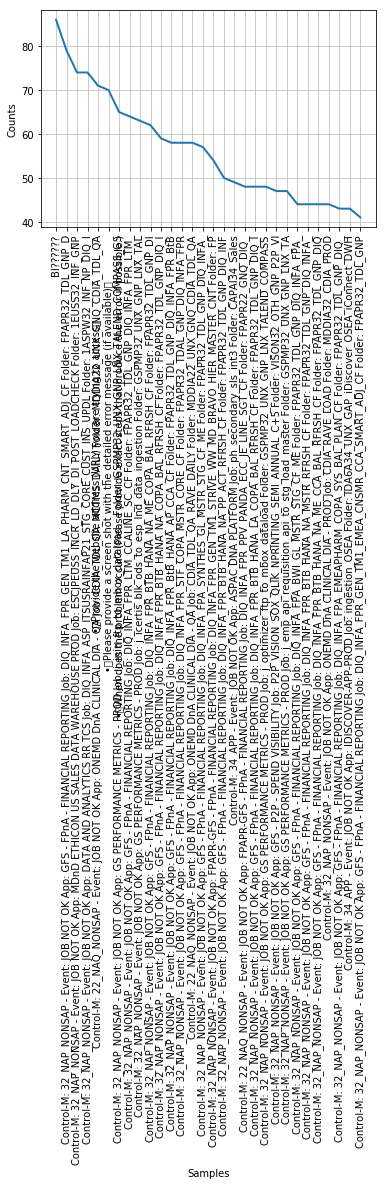

In [70]:
count = nltk.FreqDist(data.Description.values)
count.plot(30)

In [71]:
final_doc = data['Description']
all_documents = tuple(final_doc)

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(all_documents)
print (tfidf_matrix.shape)
print(tfidf_matrix)

(54750, 62982)
  (0, 55096)	0.5718495739223897
  (0, 21808)	0.30139048659914214
  (0, 47227)	0.23555550086992127
  (0, 61850)	0.11782349076087231
  (0, 46566)	0.24570229355185638
  (0, 62010)	0.15824465894131173
  (0, 35876)	0.6537370123276349
  (1, 62010)	0.17230917246641106
  (1, 32429)	0.2389315291709269
  (1, 27487)	0.16894934961229022
  (1, 5359)	0.3116071485049222
  (1, 27492)	0.1833288691369816
  (1, 4119)	0.47839280221629554
  (1, 31282)	0.262380867774427
  (1, 56263)	0.19725831005234515
  (1, 31663)	0.16196976715047132
  (1, 31624)	0.21505949204217537
  (1, 11256)	0.5872562277233079
  (2, 32429)	0.07956605636481931
  (2, 27487)	0.11252289323804104
  (2, 5359)	0.20753520498239972
  (2, 27492)	0.12209987677780765
  (2, 32404)	0.11374285111875372
  (2, 57524)	0.12798756278954507
  (2, 60797)	0.11888706068102467
  :	:
  (54748, 22796)	0.25674736940302867
  (54748, 46968)	0.3260266838583067
  (54748, 23943)	0.3978697792068459
  (54748, 41995)	0.46226458141485655
  (54748, 22955)	0.

In [81]:
reindexed_data= data["Description"]

data_text = data[['Description']]
data_text['index'] = data_text.index
documents=data_text


print(len(documents))
print(documents[:7])

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk


def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 6:
            result.append(lemmatize_stemming(token))
    return result

54750
                                         Description  index
0  SIMS  blank page when open with IE\r\n??IE ??S...      0
1  For dim_slt_id=203, dim_task_id=1658 exited wi...      1
2  For DIM_SLT_ID=203, following task(s) violated...      2
3                                             ??????      3
4                            > DS huddle Login issue      4
5  This is just a question.\r\nDo Secondary Admin...      5
6  When did this issue begin?:2018-09-28\n\nWho i...      6


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [83]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
stemmer.stem('identified')


doc_sample = documents[documents['index'] == 6].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))


processed_docs = documents['Description'].map(preprocess)
processed_docs[:7]

original document: 
['When', 'did', 'this', 'issue', 'begin?:2018-09-28\n\nWho', 'is', 'this', 'affecting?:Sales', 'force', 'in', 'SG,', 'MY\n\nWhat', 'is', 'the', 'issue?:not', 'correct', 'data', 'on', 'report.', 'This', 'is', 'follow', 'up', 'from', 'INC000018930343.', '\nin', 'SFE', 'dashboard:', 'for', 'Monthly', 'cycle', 'plan,', 'it’s', 'working', 'as', 'expected', 'for', '1', 'month.', 'But', 'if', 'more', 'than', '1', 'months', 'is', 'selected,', 'the', '“Average', 'Calls/Day”', 'is', 'sum', 'up', 'from', 'those', 'months', 'instead', 'of', 'Average.\n\nWhat', 'is', 'the', 'business', 'impact?:\n\nHave', 'you', 'attempted', 'any', 'troubleshooting?:No\n\nWhat', 'troubleshooting', 'steps', 'have', 'you', 'taken?:']


 tokenized and lemmatized document: 
['affect', 'correct', 'dashboard', 'monthli', 'work', 'expect', 'select', 'averag', 'instead', 'averag', 'busi', 'attempt', 'troubleshoot', 'troubleshoot']


0                                                   []
1               [dim_slt_id, dim_task_id, fact_run_id]
2    [dim_slt_id, follow, violat, task_end_delay, c...
3                                                   []
4                                                   []
5    [question, secondari, account, admin_ssekino, ...
6    [affect, correct, dashboard, monthli, work, ex...
Name: Description, dtype: object

## LDA with Gensim:

### Create a dictionary from the data, then convert to bag-of-words corpus and save the dictionary and corpus for future use.

In [84]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 dim_slt_id
1 dim_task_id
2 fact_run_id
3 constraint
4 end_tim
5 follow
6 start_tim
7 task_end_delay
8 task_nam
9 violat
10 account


In [85]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[123]

[(5, 1), (41, 1), (61, 1), (62, 1), (98, 1), (230, 2)]

In [86]:
#Preview Bag Of Words for our sample preprocessed document.
bow_doc_123 = bow_corpus[123]
for i in range(len(bow_doc_123)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_123[i][0], 
                                               dictionary[bow_doc_123[i][0]], 
bow_doc_123[i][1]))

Word 5 ("follow") appears 1 time.
Word 41 ("insight") appears 1 time.
Word 61 ("miss") appears 1 time.
Word 62 ("record") appears 1 time.
Word 98 ("ingest") appears 1 time.
Word 230 ("app_view") appears 2 time.


In [87]:
#TF-IDF
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[]


### Finding out 5 topics using LDA

In [89]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=7, id2word=dictionary, passes=2, workers=2)

In [90]:
# Print the results
import pickle

# Here we can assign topic names to each topic list, you can specify the number of words you want to have shown (e.g num_words = 5)
result = lda_model.print_topics(num_topics=7, num_words=7)
print(result)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

[(0, '0.076*"connect" + 0.062*"provid" + 0.054*"idiscov" + 0.036*"websit" + 0.036*"messag" + 0.033*"troubleshoot" + 0.028*"problem"'), (1, '0.041*"attach" + 0.029*"applic" + 0.020*"support" + 0.018*"tableau" + 0.017*"consum" + 0.016*"display" + 0.016*"miss"'), (2, '0.067*"product" + 0.060*"failur" + 0.037*"request" + 0.025*"execut" + 0.019*"detail" + 0.018*"run" + 0.017*"ethicon"'), (3, '0.387*"control" + 0.219*"report" + 0.088*"financi" + 0.047*"analyt" + 0.029*"platform" + 0.024*"metric" + 0.016*"assign"'), (4, '0.224*"troubleshoot" + 0.130*"busi" + 0.116*"affect" + 0.113*"attempt" + 0.015*"perform" + 0.012*"consum" + 0.010*"report"'), (5, '0.154*"dim_task_id" + 0.142*"task_nam" + 0.123*"start_tim" + 0.123*"end_tim" + 0.085*"dim_slt_id" + 0.080*"follow" + 0.075*"violat"'), (6, '0.026*"account" + 0.024*"password" + 0.024*"process" + 0.023*"custom" + 0.020*"request" + 0.018*"cognosisapi" + 0.017*"servic"')]
Topic: 0 
Words: 0.076*"connect" + 0.062*"provid" + 0.054*"idiscov" + 0.036*"we

In [91]:
# put these in a file and name the topics
with open("lda_topics_result.txt", "w") as f:
    for s in result:
        f.write(str(s) +"\n")

### pyLDAvis help to interpret the topics in a topic model that has been fit to a corpus of text data

In [92]:
# Visualize
import pyLDAvis.gensim

lda_display = pyLDAvis.gensim.prepare(lda_model, bow_corpus,dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [98]:
from collections import OrderedDict

data_lda = {i: OrderedDict(lda_model.show_topic(i,25)) for i in range(7)}

In [99]:
data.Resolution_category.value_counts()

Data Issue                           15233
Job Failure                          14386
Software                              6440
User Access or Password               5666
User knowledge or training error      4559
Open in Error or Ticket Cancelled     4277
Hardware                              4189
Name: Resolution_category, dtype: int64

In [100]:
import pandas as pd

df_lda = pd.DataFrame(data_lda)
print(df_lda.shape)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(136, 7)
(7, 136)


In [101]:
df_lda

,account,address,affect,analyt,android,applic,asl_td,assign,attach,attempt,...,unfortun,updat,usuario,version,violat,visibl,warehous,webpag,websit,work
0,0.000000,0.021531,0.018007,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.018093,...,0.000000,0.000000,0.008943,0.00000,0.000000,0.00000,0.000000,0.00000,0.035687,0.000000
1,0.008556,0.000000,0.000000,0.000000,0.00000,0.029331,0.000000,0.000000,0.040728,0.000000,...,0.000000,0.000000,0.000000,0.00873,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.00000,0.010632,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.009356,0.00000,0.013610,0.000000
3,0.000000,0.000000,0.000000,0.046887,0.01065,0.000000,0.000000,0.016061,0.000000,0.000000,...,0.002478,0.000000,0.000000,0.00000,0.000000,0.00878,0.000000,0.00463,0.000000,0.000000
4,0.000000,0.000000,0.115503,0.000000,0.00000,0.004433,0.000000,0.000000,0.008620,0.113223,...,0.000000,0.003654,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.001306,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.074704,0.00000,0.000000,0.00000,0.000000,0.000000
6,0.026357,0.000000,0.000000,0.000000,0.00000,0.011885,0.000000,0.000000,0.010585,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.013473


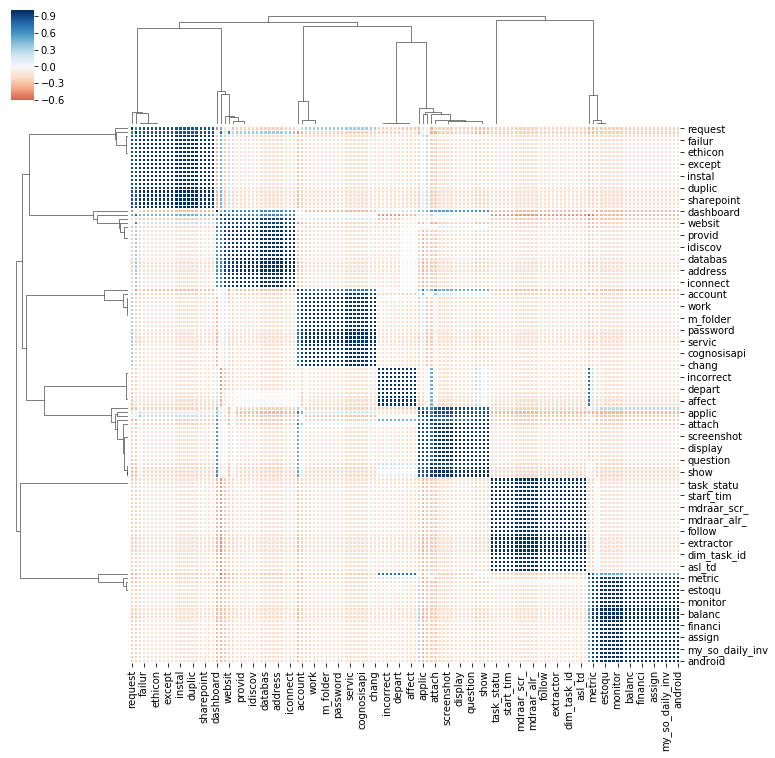

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g=sns.clustermap(df_lda.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

## Deep Learning Model Simple

In [103]:
MAX_LENGTH = 300
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.Description.values)
post_seq = tokenizer.texts_to_sequences(data.Description.values)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)

In [114]:
def data_set_split (y):
    X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.10,random_state=42)
    return X_train, X_test, y_train, y_test

In [115]:

vocab_size = len(tokenizer.word_index) + 1

In [116]:
#Vocabulary Size
vocab_size

62458

In [117]:
from sklearn.externals import joblib

In [118]:
def model_training(num_class, model_file):    
    inputs = Input(shape=(MAX_LENGTH, ))
    #300 vectors with 128 dimmensions with a vocabulary size of 62458
    embedding_layer = Embedding(vocab_size,
                            128,
                            input_length=MAX_LENGTH)(inputs)
    x = Flatten()(embedding_layer)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(num_class, activation='softmax')(x)
    model = Model(inputs=[inputs], outputs=predictions)
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
    model.summary()
    checkpointer = ModelCheckpoint(model_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    history = model.fit([X_train], batch_size=124, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=10, callbacks=[checkpointer])
    
    df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
    g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
    g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')
    
    return model

### Training Model to predict Resolution Category of the ticket

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 300, 128)          7994624   
_________________________________________________________________
flatten_2 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1228832   
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 231       
Total params: 9,223,687
Trainable params: 9,223,687
Non-trainable params: 0
_________________________________________________________________
Train on 36956 samples, validate on 12319 samples
Epoch 1/10
36956/36956 [==============================] - 32s 860us/step - loss: 1

['model-simple_sol.pkl']

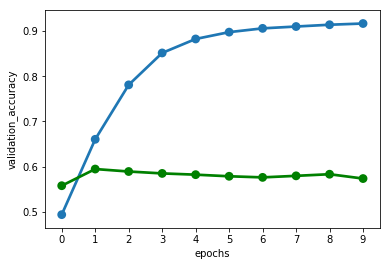

In [119]:
X_train, X_test, y_train, y_test = data_set_split(y_sol)

model_file = 'weights-simple_sol.hdf5'
model = model_training(num_class_sol, model_file)
joblib.dump(model,'model-simple_sol.pkl')

In [193]:
predicted = model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.5825266362252663

In [179]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

In [180]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import itertools

In [181]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
#This should be adjusted to the Predictor
encoder.fit(data.Resolution_category.values)
text_labels = encoder.classes_ 


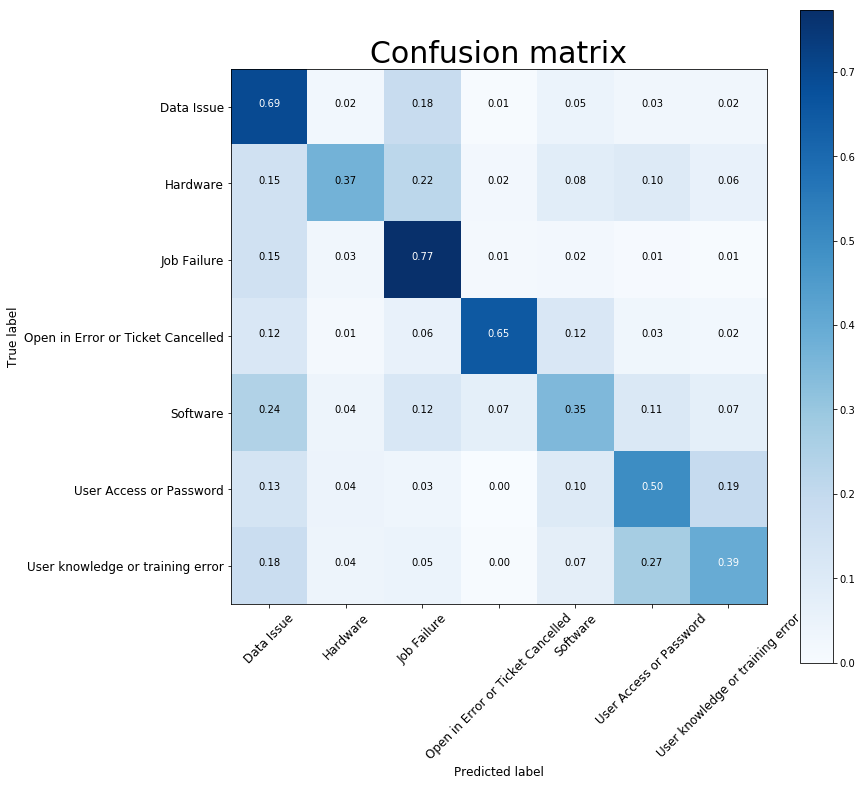

In [182]:
cnf_matrix = confusion_matrix(y_test, predicted)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

## RNN with LSTM Layer

In [183]:
def lstm_model_training(num_class, model_file): 
    inputs = Input(shape=(MAX_LENGTH, ))
    embedding_layer = Embedding(vocab_size,
                                128,
                                input_length=MAX_LENGTH)(inputs)
    #LSTM(64)(embedding_layer)
    x = LSTM(100, dropout=0.2, recurrent_dropout=0.5)(embedding_layer)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(num_class, activation='softmax')(x)
    model_lstm = Model(inputs=[inputs], outputs=predictions)
    model_lstm.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['acc'])
    model_lstm.summary()

    checkpointer = ModelCheckpoint(model_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    history = model_lstm.fit([X_train], batch_size=100, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
                             shuffle=True, epochs=10, callbacks=[checkpointer])
    
    df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
    g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
    g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')
    return model_lstm


### Training Predictor for Resolution Category using LSTM RNN

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/anaconda3/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 500, 128)          7994624   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 231       
Total params: 8,089,687
Trainable params: 8,089,687
Non-trainable params: 0
_________________________________________________________________
Train on 39009 samples, validate on 13003 samples
Epoch 1/30
39009/39009 [==============================] - 215s 6ms/step - loss: 1.

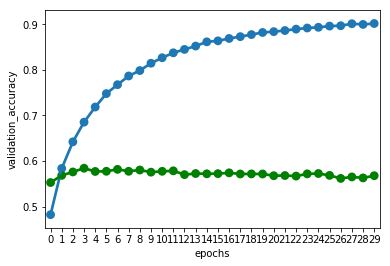

In [184]:
X_train, X_test, y_train, y_test = data_set_split(y_sol)
model_lstm = lstm_model_training(num_class_sol,"weights_sol.hdf5")
joblib.dump(model_lstm,'model_sol.pkl')
predicted = model_lstm.predict(X_test)

In [185]:
#After adding drop out to reduce overfitting and increasin batch
predicted = model_lstm.predict(X_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.5756026296566837

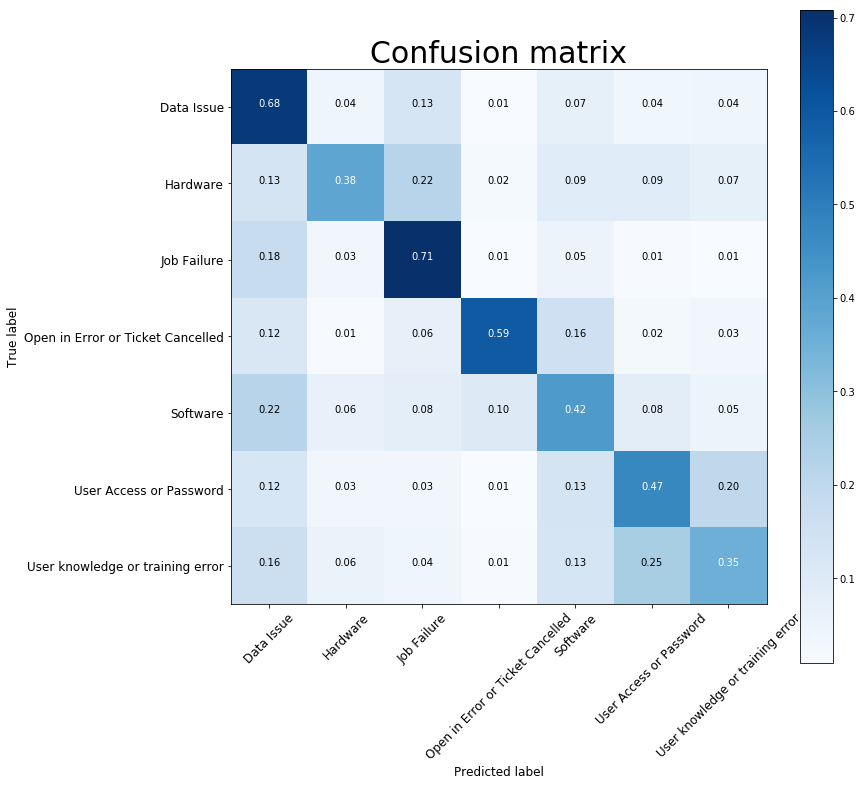

In [186]:
cnf_matrix = confusion_matrix(y_test, predicted)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

In [187]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.60      0.68      0.64       733
           1       0.45      0.38      0.41       208
           2       0.72      0.71      0.71       722
           3       0.68      0.59      0.63       217
           4       0.42      0.42      0.42       357
           5       0.46      0.47      0.47       267
           6       0.40      0.35      0.37       234

   micro avg       0.58      0.58      0.58      2738
   macro avg       0.53      0.52      0.52      2738
weighted avg       0.57      0.58      0.57      2738

